In [1]:
%matplotlib notebook

import datetime
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 4.0)

import load_hats

start_day, end_day = '2016-04-01', '2018-05-31'

In [2]:
def read_met(site, yyyy):
    met_ftp = f'/aftp/met/{site}/'
    met_file = f'met_{site}_insitu_1_obop_hour_{yyyy}.txt'
    df = pd.read_csv(met_ftp+met_file, 
                delim_whitespace=True,
                names=['site','year','month','day','hour','wind_dir','wind_speed','wind_steady','press','temp2','temp10','jj','jk','jl'],
                parse_dates = {'date':[1,2,3,4]},
                infer_datetime_format=True,
                index_col='date',
                na_values=['-999.9', '-999', '-99']
                )
    df.drop(['temp2','temp10','jj','jk','jl'], axis=1, inplace=True)
    return df

<h1>Load NOAA met data

In [3]:
dfs = []
for y in [2016, 2017, 2018]:
    df = read_met('mlo', y)
    dfs.append(df)
met = pd.concat(dfs, axis=0)
met = met[start_day:end_day]

In [4]:
met.head()

,site,wind_dir,wind_speed,wind_steady,press
date,,,,,
2016-04-01 00:00:00,MLO,320.0,7.0,99,681.50
2016-04-01 01:00:00,MLO,321.0,6.7,99,681.42
2016-04-01 02:00:00,MLO,319.0,5.6,98,681.57
2016-04-01 03:00:00,MLO,320.0,5.1,98,681.79
2016-04-01 04:00:00,MLO,304.0,3.7,98,682.15


<h1>Load CATS data

In [5]:
cats = load_hats.CATS_FTP()
mlo = cats.hourly('f11', 'mlo')
mlo = mlo[start_day:end_day].dropna()

In [6]:
mlo.head()

,mlo_mr,mlo_sd
date,,
2016-04-01 00:59:00,230.767,0.729
2016-04-01 01:59:00,229.880,0.732
2016-04-01 02:59:00,232.055,0.732
2016-04-01 03:59:00,229.975,0.731
2016-04-01 04:59:00,230.878,0.731


<h2>Merge dataframes and interpolate wind speed and direction

In [7]:
full = pd.concat([mlo, met], axis=1)
full['wind_dir'] = full.wind_dir.interpolate()
full['wind_speed'] = full.wind_speed.interpolate()
full = full.drop(['site', 'wind_steady', 'press'], axis=1).dropna()
full.head()

,mlo_mr,mlo_sd,wind_dir,wind_speed
date,,,,
2016-04-01 00:59:00,230.767,0.729,320.5,6.85
2016-04-01 01:59:00,229.880,0.732,320.0,6.15
2016-04-01 02:59:00,232.055,0.732,319.5,5.35
2016-04-01 03:59:00,229.975,0.731,312.0,4.40
2016-04-01 04:59:00,230.878,0.731,277.5,3.10


<h2>Identify local day and night samples

In [8]:
full = full.reset_index()
full = full.assign(local=(full.date.dt.tz_localize('utc').dt.tz_convert('US/Hawaii')))
full = full.set_index(full.date)

In [9]:
full = full.assign(night=((full.local.dt.hour >= 22)|(full.local.dt.hour <= 8))&(full.wind_dir<=250)&(full.wind_dir>=110))
full = full.assign(day=(full.local.dt.hour >= 10)&(full.local.dt.hour <= 20))

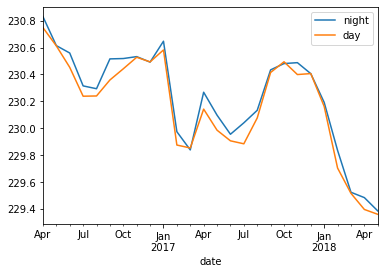

In [10]:
full.loc[full.night==True].mlo_mr.resample('M').mean().plot(label='night')
full.loc[full.day==True].mlo_mr.resample('M').mean().plot(label='day')
plt.legend()

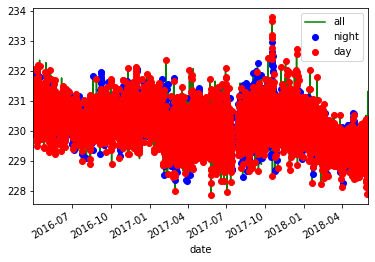

In [11]:
full.mlo_mr.plot(color='g', label='all')
full.loc[full.night==True].mlo_mr.plot(marker='o', linestyle='None', color='b', label='night')
full.loc[full.day==True].mlo_mr.plot(marker='o', linestyle='None', color='r', label='day')
plt.legend()

<h2>Select daily night time sample

In [12]:
#clean = full.assign(week=(full.local.dt.weekday_name == 'Saturday'))
#clean = clean.loc[(clean.week==True)&(clean.night==True)]
#clean = full.loc[full.night==True]
clean = full.loc[(full.local.dt.hour==3)|(full.local.dt.hour==4)]
# if more than one data point per week, select the first
clean = clean.assign(dd=clean.date.diff()>datetime.timedelta(0,4*3600))
clean = clean.loc[clean.dd==True]
clean.drop(['date','night','day','dd'], axis=1, inplace=True)

In [13]:
clean.head()

,mlo_mr,mlo_sd,wind_dir,wind_speed,local
date,,,,,
2016-04-02 13:01:00,230.584,0.826,222.5,3.4,2016-04-02 03:01:00-10:00
2016-04-03 13:02:00,230.497,0.926,211.0,2.7,2016-04-03 03:02:00-10:00
2016-04-04 13:04:00,230.589,0.959,173.5,7.3,2016-04-04 03:04:00-10:00
2016-04-05 13:05:00,230.618,0.884,212.5,4.2,2016-04-05 03:05:00-10:00
2016-04-06 13:07:00,230.829,0.863,229.5,4.2,2016-04-06 03:07:00-10:00


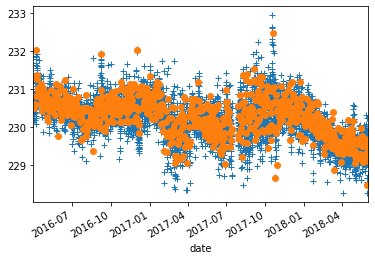

In [14]:
full.loc[full.night==True].mlo_mr.plot(marker='+', linestyle='None')
clean.mlo_mr.plot(marker='o', linestyle='None')

In [15]:
print(f"Number of measurements full:{full.shape[0]} clean:{clean.shape[0]}")

Number of measurements full:17364 clean:759


In [16]:
clean.to_csv('mlo-clean.csv')
full.loc[full.night==True].to_csv('mlo-night.csv')

<h2>Select one random day time and night time sample per day.

In [61]:
df = full.loc[full.night==True]
random.seed(995)
rnd_n = df.groupby(df.index.date).apply(lambda x :x.iloc[random.choice(range(0,len(x)), )])

In [62]:
df = full.loc[full.day==True]
random.seed(995)
rnd_d = df.groupby(df.index.date).apply(lambda x :x.iloc[random.choice(range(0,len(x)), )])

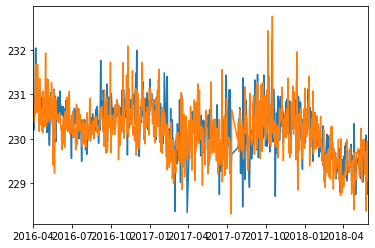

In [63]:
rnd_n.mlo_mr.plot()
rnd_d.mlo_mr.plot()

In [64]:
rnd = pd.concat([rnd_n, rnd_d])
rnd = rnd.set_index(rnd.date).sort_index()

Number of measurements full:17364 daily:1514


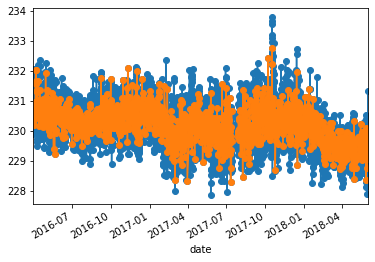

In [65]:
rnd.set_index(rnd.date, inplace=True)
rnd.drop(['date'], axis=1, inplace=True)
del df

full.mlo_mr.plot(marker='o')
rnd.mlo_mr.plot(marker='o')

print(f"Number of measurements full:{full.shape[0]} daily:{rnd.shape[0]}")

In [72]:
full.drop(['date','night','day','local'], axis=1).to_csv('mlo-full.csv')
rnd.drop(['night','day','local'], axis=1).to_csv('mlo-random-daily.csv')